# Triplet Loss with Faces -- Determine Threshold

## Initialization

In [ ]:
# !pip install torch

In [ ]:
# !pip install mat73

In [ ]:
# !pip install wandb -qqq
# import wandb

In [ ]:
# !git clone https://github.com/mgornet/CNPEN

### Check device

In [1]:
!nvidia-smi

Fri Jun 24 15:27:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A400...  On   | 00000000:01:00.0  On |                  N/A |
| N/A   70C    P0    54W /  N/A |   7681MiB /  8192MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Import Librairies

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from time import perf_counter
from typing import Callable
import itertools
import mat73
import pandas as pd
import re

import sys
import os
import tarfile

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

import os.path as op
try:
    from urllib.request import urlretrieve
except ImportError:  # Python 2 compat
    from urllib import urlretrieve
    
from sklearn.metrics import confusion_matrix, auc, roc_curve, \
precision_recall_curve, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from scipy import optimize
import wandb

In [3]:
%cd ./files/

from triplet import TripletGenerator, TripletLearner, TripletLoss, TripletLossRaw, \
distance, distance_vectors
from builder import create_dataframe, from_tensor_to_numpy, from_numpy_to_tensor, extend_dataframe
from prints import print_img, print_img_from_path, print_img_from_id, \
print_img_from_classid, print_from_gen, print_from_gen2, print_pair, print_hist_loss, \
print_hist_dist, print_hist_dist_zoom, print_img_category, \
print_roc, print_logistic_regression, print_prec_recall
from test_train_loops import training, testing, adaptative_train, compute_distances
from classification import authentification_img, predict, triplet_acc

/home/mgornet/Bureau/Code/CNPEN/files


In [4]:
!pwd

/home/mgornet/Bureau/Code/CNPEN/files


## Generate Data

### Create dataframe

In [5]:
URL = "http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz"
FILENAME = "lfw-deepfunneled.tgz"

if not op.exists(FILENAME):
    print('Downloading %s to %s...' % (URL, FILENAME))
    urlretrieve(URL, FILENAME)

if not op.exists("lfw"):
    print('Extracting image files...')
    tar = tarfile.open("lfw-deepfunneled.tgz")
    tar.extractall("lfw")
    tar.close()

In [6]:
PATH = "lfw/lfw-deepfunneled/"

In [7]:
tic = perf_counter()
df_init, all_imgs = create_dataframe()
toc = perf_counter()
print(f"DataFrame creation: {((toc - tic)/60):.1f} min")

Number of individuals:  5749
Number of total images:  13233
images weigh  0.57 GB
DataFrame creation: 0.9 min


In [8]:
tic = perf_counter()
df = extend_dataframe(df_init)
toc = perf_counter()
print(f"DataFrame extention: {((toc - tic)/60):.1f} min")

DataFrame extention: 0.1 min


### Build sets, generators and network

In [9]:
num_classes = len(df.Classid.unique())
print("Number of individuals: ", num_classes)

Number of individuals:  5749


In [10]:
indiv_min = df.Classid.min()
split_train_valid = int(num_classes * 0.75)
split_train_test = int(num_classes * 0.8)
indiv_max = df.Classid.max()

In [11]:
print(f"Train set from indiv {indiv_min} to {split_train_valid-1}")
print(f"Valid set from indiv {split_train_valid} to {split_train_test-1}")
print(f"Test set from indiv {split_train_test} to {indiv_max}")

Train set from indiv 0 to 4310
Valid set from indiv 4311 to 4598
Test set from indiv 4599 to 5748


In [12]:
df_train = df[df.Classid<split_train_valid]
df_valid = df[(df.Classid>=split_train_valid)]#&(df.Classid<split_train_test)]
# df_test = df[df.Classid>=split_train_test]
df_test = df_valid

In [13]:
print("Number of training images: ", len(df_train))
print("Number of validation images: ", len(df_valid))
print("Number of testing images: ", len(df_test))
print("Number of total images: ", len(df_train)+len(df_valid)+len(df_test))
print("len original: ", len(df))

Number of training images:  10060
Number of validation images:  3173
Number of testing images:  3173
Number of total images:  16406
len original:  13233


In [14]:
print("Number of individuals in the training set: ", len(df_train.Classid.unique()))
print("Number of individuals in the validation set: ", len(df_valid.Classid.unique()))
print("Number of individuals in the testing set: ", len(df_test.Classid.unique()))

Number of individuals in the training set:  4311
Number of individuals in the validation set:  1438
Number of individuals in the testing set:  1438


In [15]:
value_count = df_train.Classid.value_counts()
print("Number of individuals with more than one image in the training set: ", len(value_count[value_count.values>1]))
value_count = df_valid.Classid.value_counts()
print("Number of individuals with more than one image in the validation set: ", len(value_count[value_count.values>1]))
value_count = df_test.Classid.value_counts()
print("Number of individuals with more than one image in the testing set: ", len(value_count[value_count.values>1]))

Number of individuals with more than one image in the training set:  1267
Number of individuals with more than one image in the validation set:  413
Number of individuals with more than one image in the testing set:  413


In [16]:
df_valid.head()

,Classid,Name,Path,Male,Asian,White,Black,Baby,Child,Youth,...,Pale Skin,5 o Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
10060,4311,Pedro_Solbes,Pedro_Solbes/Pedro_Solbes_0001.jpg,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
10061,4311,Pedro_Solbes,Pedro_Solbes/Pedro_Solbes_0002.jpg,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
10062,4311,Pedro_Solbes,Pedro_Solbes/Pedro_Solbes_0003.jpg,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
10063,4311,Pedro_Solbes,Pedro_Solbes/Pedro_Solbes_0004.jpg,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
10064,4312,Pedro_Velasquez,Pedro_Velasquez/Pedro_Velasquez_0001.jpg,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [17]:
BATCH_SIZE = 128 # 128
BATCH_VALID_SIZE = 128 #128 #8
BATCH_TEST_SIZE = 128 #128 #32

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
margin = 0.2
criterion = TripletLoss(margin)
criterion_test = TripletLossRaw(margin)

### Load Model

In [20]:
# Load pretrained model

model = TripletLearner(base_channels=32)
model.load_state_dict(torch.load("../models/in_article/base_121_600.pth",map_location=torch.device('cpu'))) #without_jitter_and_p
model = model.to(device)
model.eval()

TripletLearner(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), 

In [21]:
# Build generator and loader

gen = TripletGenerator(df_valid, all_imgs, BATCH_VALID_SIZE, device, model, margin)
loader = DataLoader(gen, batch_size=None, shuffle=True)

/home/mgornet/Bureau/Code/CNPEN/files/triplet.py:253: UserWarning: Number of unique identities with more than 2 pictures (413) is not divisible by batch_size (128). Remainder: 29
  warnings.warn(


In [22]:
# Concatenate to augment the loader size

list_loader = []
for _ in range(10):
    list_loader.extend(list(loader))

## Build THRESHOLD

### Print histograms

In [23]:
pos_dist, neg_dist, _ = compute_distances(list_loader, device, model) #loader

Processing:   0%|          | 0/30 [00:00<?, ?it/s]

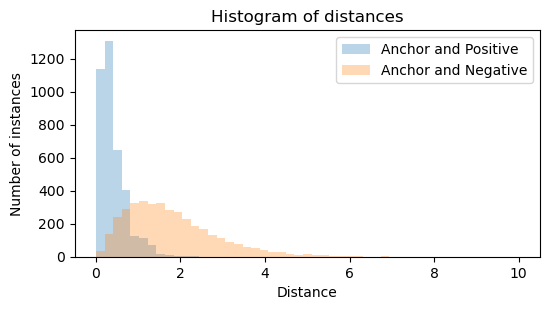

In [24]:
print_hist_dist(pos_dist,neg_dist)

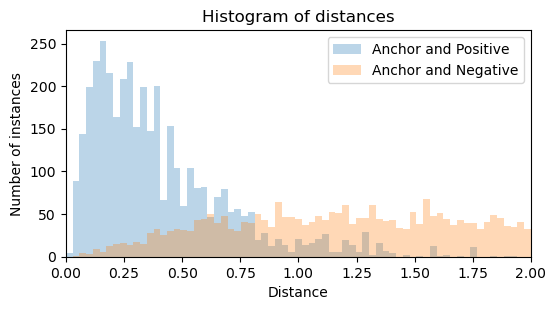

In [25]:
print_hist_dist_zoom(pos_dist,neg_dist)

### ROC curve with distance

In [26]:
# Create y (true) and X (distances)

y_pos = [1 for _ in range(len(pos_dist))]
y_neg = [0 for _ in range(len(neg_dist))]

y = y_pos + y_neg
X = pos_dist + neg_dist

In [27]:
# We need the opposite of the distances

Xmoins = np.array(X)*(-1)
Xmoins.shape

(7680,)

In [28]:
# Compute FPR and TPR for ROC curve from distance

fpr_dist, tpr_dist, thresholds_dist = roc_curve(y, Xmoins)
roc_auc_dist = auc(fpr_dist,tpr_dist)

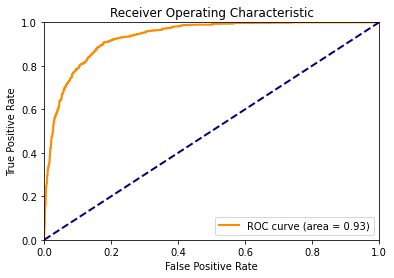

In [29]:
print_roc(fpr_dist, tpr_dist, roc_auc_dist)

In [30]:
# Different possible thresholds from the ROC curve of distances

print("max(TPR-FPR):", -thresholds_dist[np.argmax(tpr_dist - fpr_dist)])
print("min(abs(TPR-(1-FPR))):", -thresholds_dist[np.argmin(abs(tpr_dist-(1-fpr_dist)))])
print("min((1-TPR)²+FPR²):", -thresholds_dist[np.argmin((1 - tpr_dist) ** 2 + fpr_dist ** 2)])

max(TPR-FPR): 0.8093509674072266
min(abs(TPR-(1-FPR))): 0.7006740570068359
min((1-TPR)²+FPR²): 0.759343147277832


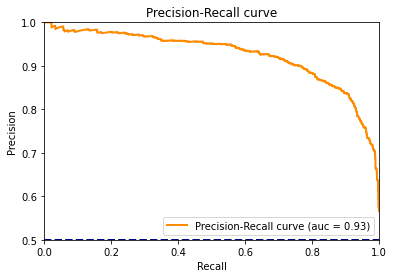

In [31]:
precision_dist, recall_dist, thresholds_recall_dist = precision_recall_curve(y, Xmoins)
auc_s_dist = auc(recall_dist, precision_dist)

print_prec_recall(precision_dist, recall_dist, auc_s_dist)

### Logistic regression

In [32]:
# Reshape distances to fit the logistic regression

Xlogistic = np.array(Xmoins).reshape(-1,1)
Xlogistic.shape

(7680, 1)

In [33]:
# Create and fit logistic regression

clf = LogisticRegression(random_state=0).fit(Xlogistic, y)

y_pred_logistic = clf.predict(Xlogistic)
y_pred_proba_logistic = clf.predict_proba(Xlogistic)

score_logistic = clf.score(Xlogistic, y)
print("Score (mean accuracy):", score_logistic)

f1_s_logistic = f1_score(y, y_pred_logistic)
print("f1 score:", f1_s_logistic)

Score (mean accuracy): 0.8631510416666667
f1 score: 0.8692298121189498


In [34]:
# Threshold from logistic regression

THRESHOLD = (clf.intercept_/clf.coef_)[0,0]
print("THRESHOLD with logistic regression:", THRESHOLD)

THRESHOLD with logistic regression: 0.8193061471833948


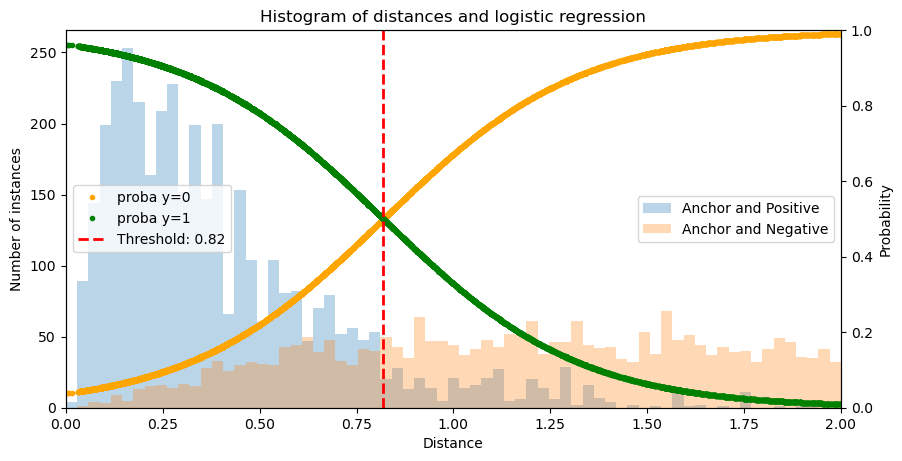

In [35]:
# Print the curves from logistic regression above the histogram and show threshold

print_logistic_regression(pos_dist, neg_dist, y_pred_proba_logistic, THRESHOLD)

In [36]:
# Confusion matrix from logistic regression

print("Confusion Matrix Total")
confusion_matrix(y, y_pred_logistic)

Confusion Matrix Total


array([[3136,  704],
       [ 347, 3493]])

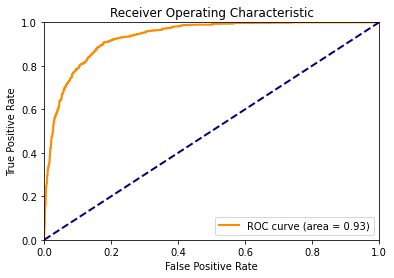

In [37]:
# Compute FPR and TPR for ROC curve from logistic regression

fpr_logistic, tpr_logistic, thresholds_logistic = roc_curve(y, y_pred_proba_logistic[:,1])
roc_auc_logistic = auc(fpr_logistic,tpr_logistic)

print_roc(fpr_logistic,tpr_logistic, roc_auc_logistic)

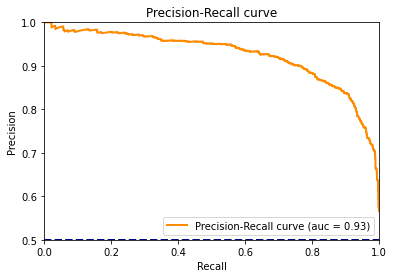

In [38]:
# Compute Precision and Recall

precision_logistic, recall_logistic, thresholds_recall_logistic = precision_recall_curve(y, y_pred_proba_logistic[:,1])
auc_s_logistic = auc(recall_logistic, precision_logistic)

print_prec_recall(precision_logistic, recall_logistic, auc_s_logistic)

In [39]:
# Different possible thresholds from the ROC curve of logistic regression

print("max(TPR-FPR):", thresholds_logistic[np.argmax(tpr_logistic - fpr_logistic)])
print("min(abs(TPR-(1-FPR))):", thresholds_logistic[np.argmin(abs(tpr_logistic-(1-fpr_logistic)))])
print("min((1-TPR)²+FPR²):", thresholds_logistic[np.argmin((1 - tpr_logistic) ** 2 + fpr_logistic ** 2)])

max(TPR-FPR): 0.5098506735104843
min(abs(TPR-(1-FPR))): 0.615290895229226
min((1-TPR)²+FPR²): 0.5590641498364759


### Compute accuracy

In [40]:
# Predict classification from THRESHOLD

y_pred_pos_bins, y_pred_neg_bins = predict(list_loader, device, model, THRESHOLD) #loader
y_pred_bins = y_pred_pos_bins + y_pred_neg_bins

In [41]:
# Confusion matrix and accuracy score from the classification
# If THRESHOLD comes from logistic regression, we should find the same confusion matrix

print("Confusion Matrix Total")
print(confusion_matrix(y, y_pred_bins))

print("\n","Accuracy score:",accuracy_score(y, y_pred_bins))

Confusion Matrix Total
[[3136  704]
 [ 347 3493]]

 Accuracy score: 0.8631510416666667


In [42]:
# Define the accuracy function

def acc(thr):
    y_pred_pos_bins, y_pred_neg_bins = predict(list_loader, device, model, thr) #loader
    y_pred_bins = y_pred_pos_bins + y_pred_neg_bins
    return(accuracy_score(y, y_pred_bins))

In [43]:
# Compute several accuracy points depending on threshold

thrs = np.linspace(0.,2.,100)
accu=[]
for i,thr in zip(enumerate(tqdm(range(len(thrs)), desc="Processing", leave=False)),thrs) :
    accu.append(acc(thr))

Processing:   0%|          | 0/100 [00:00<?, ?it/s]

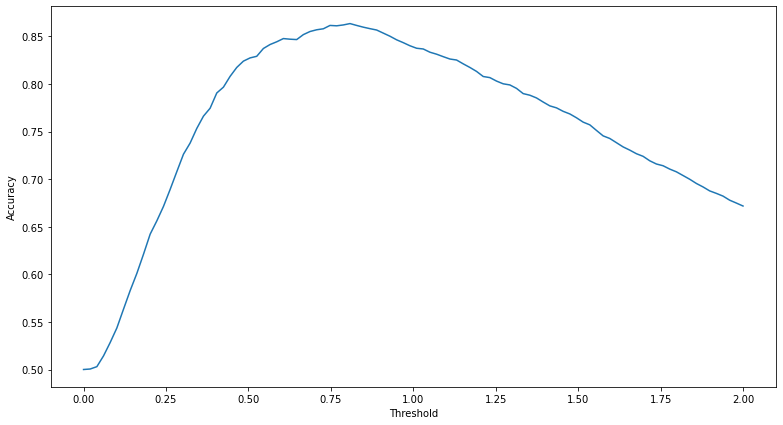

In [44]:
# Plot accuracy(threshold)

plt.figure(figsize=(13,7))
plt.plot(thrs, accu)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.show()

In [51]:
val, idx = max((val, idx) for (idx, val) in enumerate(accu))
print(f"accuracy of {val} at index {idx} for threshold {thrs[idx]}")

accuracy of 0.8634114583333333 at index 40 for threshold 0.8080808080808082


In [53]:
val*0.95

0.8202408854166666

In [62]:
min(enumerate(accu), key=lambda x: abs(x[1]-val*0.95))

(57, 0.82109375)

In [54]:
thrs2 = np.linspace(0.5,1.,100)
accu2 = []
for i,thr in zip(enumerate(tqdm(range(len(thrs2)), desc="Processing", leave=False)),thrs2) :
    accu2.append(acc(thr))

Processing:   0%|          | 0/100 [00:00<?, ?it/s]

In [56]:
val2, idx2 = max((val, idx) for (idx, val) in enumerate(accu2))
print(f"accuracy of {val2} at index {idx2} for threshold {thrs2[idx2]}")

accuracy of 0.8639322916666666 at index 60 for threshold 0.803030303030303


In [67]:
min(enumerate(thrs), key=lambda x: abs(x[1]-1.))

(49, 0.98989898989899)

In [68]:
accu[49]

0.8401041666666667

In [69]:
min(enumerate(thrs), key=lambda x: abs(x[1]-0.5))

(25, 0.5050505050505051)

In [74]:
accu[24], thrs[24]

(0.8239583333333333, 0.48484848484848486)

In [83]:
accu[57], thrs[57]

(0.82109375, 1.1515151515151516)

In [ ]:
# Define a the opposite function

def acc_moins(thr, loader=list_loader):
    y_pred_pos_bins, y_pred_neg_bins = predict(list_loader, device, model, thr)
    y_pred_bins = y_pred_pos_bins + y_pred_neg_bins
    return(-accuracy_score(y, y_pred_bins))

In [ ]:
# Use the Brent otpimizer to find the maximum of accuracy

xmin, fval, niter, funcalls = optimize.brent(acc_moins,brack=(0.,2.), full_output=True, maxiter=1000)
print(f"Maximum of accuracy ({-round(fval,3)}) found for threshold = {xmin}")

In [ ]:
acc, thr = [], []

for _ in range(4):
    list_loader = []
    for _ in range(10):
        list_loader.extend(list(loader))
    xmin, fval, niter, funcalls = optimize.brent(acc_moins,brack=(0.,2.), full_output=True, maxiter=100)
    acc.append(-fval)
    thr.append(xmin)

In [ ]:
import statistics

In [ ]:
print("Accuracy:", acc)
print("Threshold: ", thr)
print("Mean accuracy:",statistics.mean(acc))
print("Mean threshold:",statistics.mean(thr))

### Triplet accuracy

In [ ]:
gen = TripletGenerator(df_valid, all_imgs, BATCH_VALID_SIZE, device, model, margin)
loader = DataLoader(gen, batch_size=None, shuffle=True)

list_loader = []
for _ in range(10):
    list_loader.extend(list(loader))

In [ ]:
len(list_loader)

In [ ]:
triplet_accuracy = triplet_acc(list_loader, device, model)
print("Triplets where d(A,P) < d(A,N): ",round(100*triplet_accuracy,1),"%")

In [ ]:
triplet_accuracy_list = []
for _ in range(100):
    list_loader = []
    for _ in range(10):
        list_loader.extend(list(loader))
    triplet_accuracy = triplet_acc(list_loader, device, model)
    triplet_accuracy_list.append(triplet_accuracy)

In [ ]:
# print(triplet_accuracy_list)
print("Mean triplet accuracy: ",statistics.mean(triplet_accuracy_list))
print("Min-Max triplet accuracy: ",[min(triplet_accuracy_list),max(triplet_accuracy_list)])

### Old method with sigmoid

In [ ]:
def sigmoid(x, c1, c2):
  
    z = np.exp(-c1*(x-c2))
    sig = 1 / (1 + z)

    return sig

In [ ]:
xx = np.arange(-10,10,0.05)
plt.plot(xx,sigmoid(xx,1.,0.))
plt.show()

In [ ]:
fig,ax1 = plt.subplots(1,1,figsize=(10,5),dpi=100,num=1)
maxi = 2.
bins=np.linspace(0.,maxi,50)
ax1.hist(pos_dist,bins=bins,label='Anchor and Positive', alpha=0.3)
ax1.hist(neg_dist,bins=bins,label='Anchor and Negative', alpha=0.3)
ax1.axvline(x=THRESHOLD, label='Threshold', color="red", linestyle="--", lw=4)
ax2 = ax1.twinx()
xx = np.arange(0,maxi,0.01)
ax2.plot(xx, sigmoid(xx, 20., THRESHOLD),label='Sigmoïd',color='navy',lw=3)
plt.xlim([0.,maxi])
ax1.set_xlabel('Distance')
ax1.set_ylabel('Number of instances')
ax1.legend(loc='center right')
ax2.legend(loc='upper right')
plt.show()

### Testing on my imgs

In [ ]:
def print_my_img(path):
    plt.imshow(resize100(imread('./my_imgs/'+path))/255)
    plt.show()

In [ ]:
MY_IMGS_PATH = './my_imgs/'

In [ ]:
print_my_img('profil_rugby.jpg')

In [ ]:
print_my_img('profil_prepa.jpg')

In [ ]:
print_my_img('img_enfant.jpg')

In [ ]:
dirs = sorted(os.listdir(MY_IMGS_PATH))
name_to_classid = {d:i for i,d in enumerate(dirs)}
classid_to_name = {v:k for k,v in name_to_classid.items()}
num_classes = len(name_to_classid)
print("number of classes: "+str(num_classes))

my_img_paths = {c:[directory + "/" + img for img in sorted(os.listdir(MY_IMGS_PATH+directory))] 
                for directory,c in name_to_classid.items()}

# retrieve all images
all_my_images_path = []
for img_list in my_img_paths.values():
    all_my_images_path += img_list

In [ ]:
all_my_images_path

In [ ]:
my_img_paths

In [ ]:
all_my_imgs = []
for path in all_my_images_path:
    all_my_imgs += [np.expand_dims(resize100(imread(MY_IMGS_PATH+path)),0)]
return np.vstack(all_imgs)

In [ ]:
def authentification(df, id_img1, id_img2, neg_imgs_idx, threshold):

    id_img3 = neg_imgs_idx[random.randint(0,len(neg_imgs_idx))]

    img1 = df.Img.iloc[id_img1]
    img2 = df.Img.iloc[id_img2]
    img3 = df.Img.iloc[id_img3]

    image_transforms = transforms.Compose(
              [
                  transforms.ToTensor(),
              ]
          )

    anchor_img = torch.reshape(image_transforms(img1).to(device).float(), (1,3,60,60))
    positive_img = torch.reshape(image_transforms(img2).to(device).float(), (1,3,60,60))
    negative_img = torch.reshape(image_transforms(img3).to(device).float(), (1,3,60,60))

    anchor_out = model(anchor_img)
    positive_out = model(positive_img)
    negative_out = model(negative_img)

    loss = criterion(anchor_out, positive_out, negative_out)
    print("Loss: ", loss.cpu().detach().numpy())

    if loss < threshold :
        return 1
    
    return 0